In [7]:
!git clone https://github.com/pjreddie/darknet
%cd darknet
!make

fatal: destination path 'darknet' already exists and is not an empty directory.
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-un

In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-08-03 14:39:05--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  78.3MB/s    in 3.0s    

2023-08-03 14:39:08 (78.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [26]:
!pip install opencv-python
!pip install numpy

import cv2
import numpy as np

from google.colab.patches import cv2_imshow

In [16]:
net = cv2.dnn.readNet("yolov3.weights", "cfg/yolov3.cfg")

classes = []
with open("data/coco.names", "r") as f:
  classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
# output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [15]:
# debug
for i in net.getUnconnectedOutLayers():
  print(i)

200
227
254


In [18]:
# from google.colab import files
# uploaded = files.upload()

img = cv2.imread("data/horses.jpg")
height, width, channels = img.shape

# what is parameter (0,0,0)
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0,0,0), True, crop = False)
net.setInput(blob)

In [19]:
# outs = array of array
outs = net.forward(output_layers)

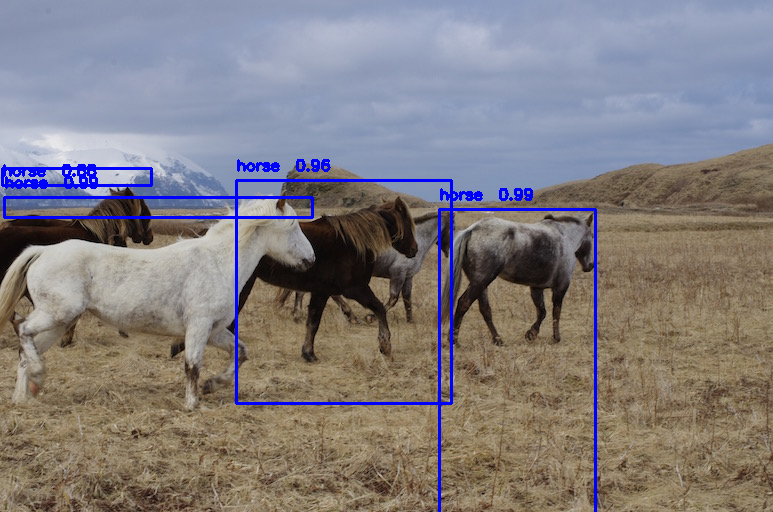

In [27]:
class_ids = []
confidences = []
boxes = []

# out = array
for out in outs:
  for detection in out:
    # why 5? - first 4 is (x,y,width, height) - x,y is top-left corner
    # if y is larger, then it moves down; if x is larger, then it moves from left to right
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence > 0.5:
      center_x = int(detection[0] * width)
      center_y = int(detection[1] * height)
      w = int(detection[2] * width)
      h = int(detection[3] * height)

      x = int(center_x - w / 2)
      y = int(center_y - h / 2)

      boxes.append([x,y,w,h])
      confidences.append(float(confidence))
      class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

for i in range(len(boxes)):
  if i in indexes:
    x,y,w,h = boxes[i]
    label = str(classes[class_ids[i]])
    confidence = confidences[i]
    color = (255, 0, 0)
    cv2.rectangle(img, (x,y), (x + w, x + h), color, 2)
    cv2.putText(img, f"{label} {confidence: .2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(img)